In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import imp
import sys
sys.path.append('/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

#### Load functions for validation tools and visualization

In [2]:
%%capture
dist = imp.load_source('*', './validation/dist.py')
matstat = imp.load_source('*', './validation/matrix.py')
testdata = imp.load_source('*', './validation/test_data.py')
vizi = imp.load_source('*', '../INM6/Tasks/viziphant/plots/generic.py')

data_path = '/home/robin/Projects/ValidationTools'
nest_path = data_path + "/sim_data/NEST_data"
spinnaker_path = data_path + "/sim_data/SpiNNaker_data"

# Number of spiketrains:
N = 100

#### Load spiketrains from simulation

spiketrain_list_1 = testdata.load_data(nest_path, ['spikes_L4'], N)[0][0]

spiketrain_list_2 = testdata.load_data(spinnaker_path, ['spikes_L4'], N)[0][0]

#### ...or generate custom spiketrains

In [3]:
spiketrain_list_1 = testdata.test_data(size=N, 
                                       corr=.0, 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                      #assembly_sizes=[10,5,3],
                                       method="CPP", 
                                       bkgr_corr=0.00)

spiketrain_list_2 = testdata.test_data(size=N, 
                                       corr=[.2], 
                                       t_stop=500*ms, 
                                       rate=100*Hz, 
                                       assembly_sizes=[10],
                                       method="CPP", 
                                       bkgr_corr=0.00)

#### Rasterplots

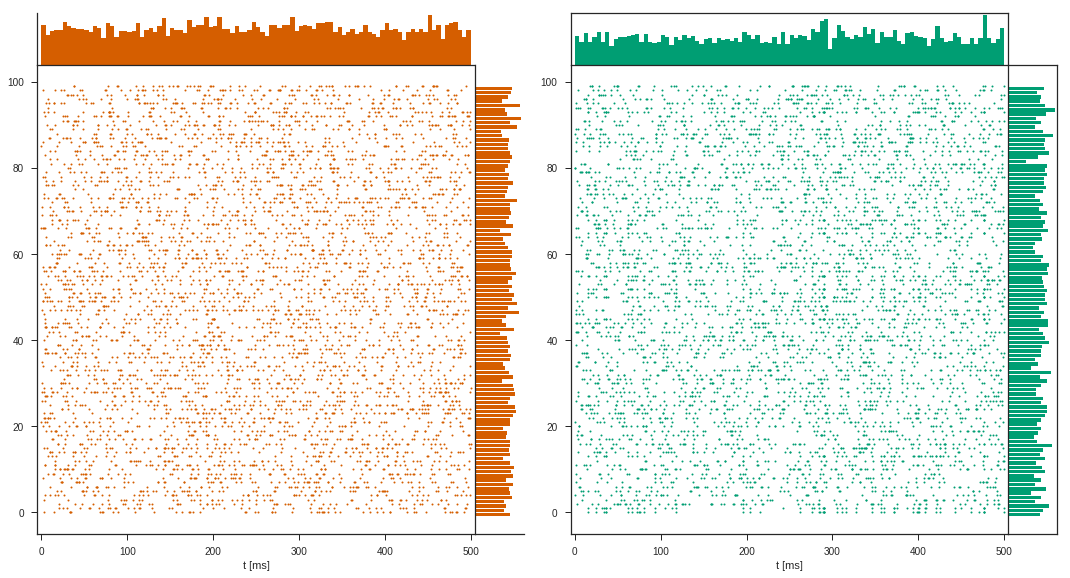

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()

__ = vizi.rasterplot(spiketrain_list_1, ax=ax[0], palette=(['r']))
__ = vizi.rasterplot(spiketrain_list_2, ax=ax[1], palette=(['g']))

### Compare distributions 
##### of CVs, firing rates, correlation coefficients, ...

In [5]:
def func(sts):
    return matstat.corr_matrix(sts).flatten() # cv(isi(x)), mean_firing_rate(x)
    
dist_sample_1 = func(spiketrain_list_1)

dist_sample_2 = func(spiketrain_list_2)

#### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The KL-Divergence is a measure of difference between two distribution based on entropy.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.


Kullback-Leidler-Divergence
	Interpreting input as data sample...
	65 zero values have been discarded.
	D_KL(P||Q) = 0.01
	D_KL(Q||P) = 0.01



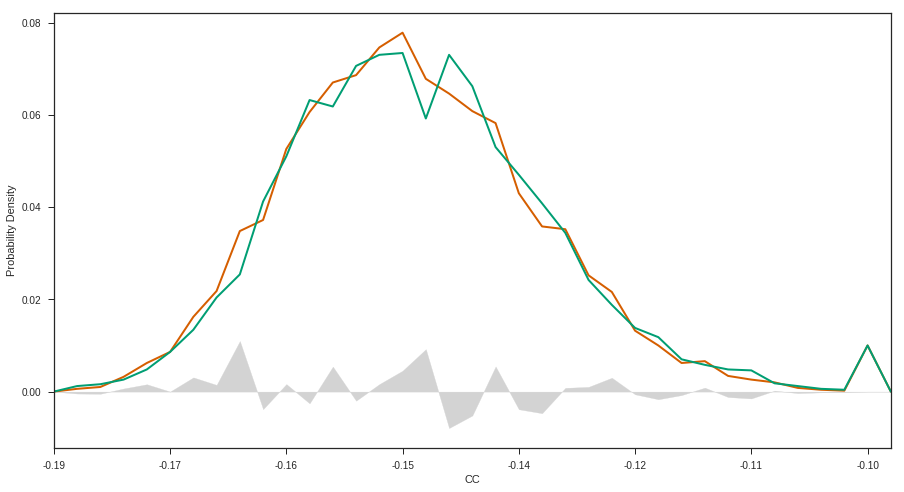

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKL, DKL_inv = dist.KL_test(dist_sample_1, dist_sample_2, ax=ax, bins=100, excl_zeros=True, xlabel='CC')

#### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The KS-Distance measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.


Kolmogorov-Smirnov-Distance
	length 1 = 10000 	 length 2 = 10000
	D_KS = 0.03 	 p value = 0.00



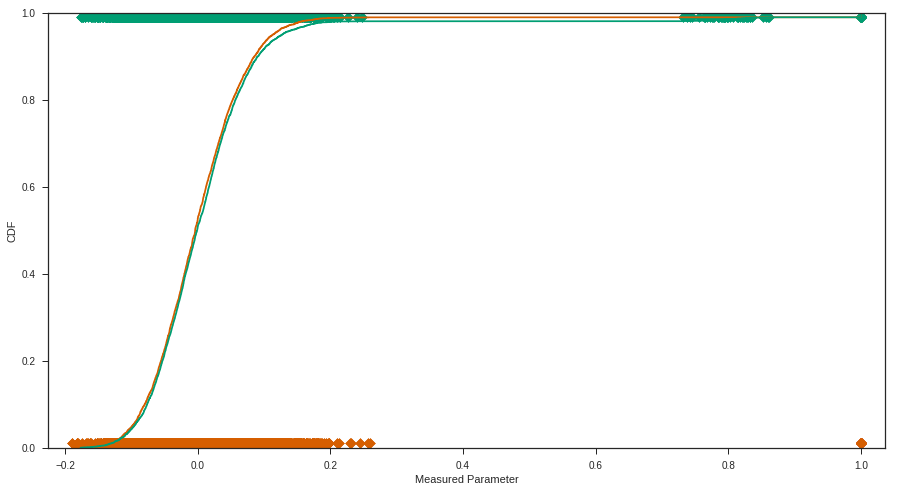

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,8))
DKS, p = dist.KS_test(dist_sample_1, dist_sample_2, ax=ax)

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The Mann-Whitney U is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.


Mann-Whitney-U-Test
	length 1 = 100 	 length 2 = 100
	U = 4530.50   	 p value = 0.25


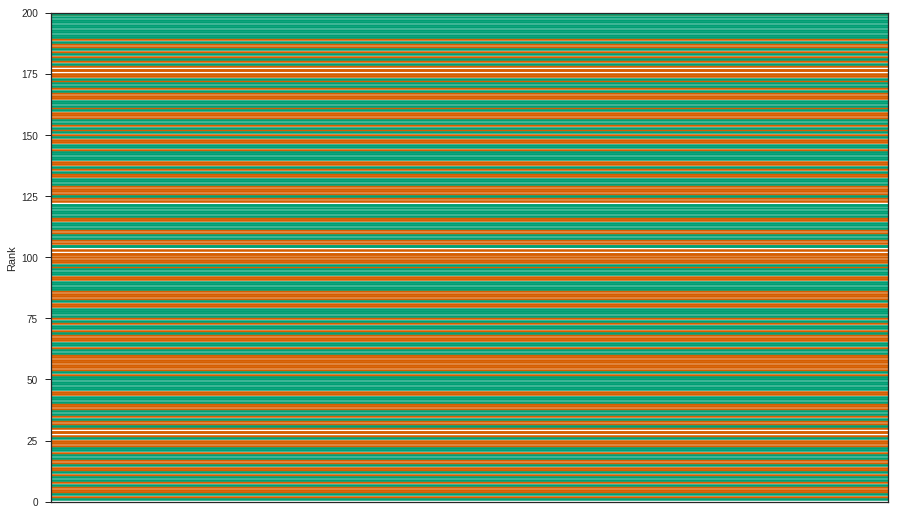

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,9))
U, p = dist.MWU_test(dist_sample_1[:100], dist_sample_2[:100], ax=ax, excl_nan=True)

### Compare the correlation matrices

#### Heatmap

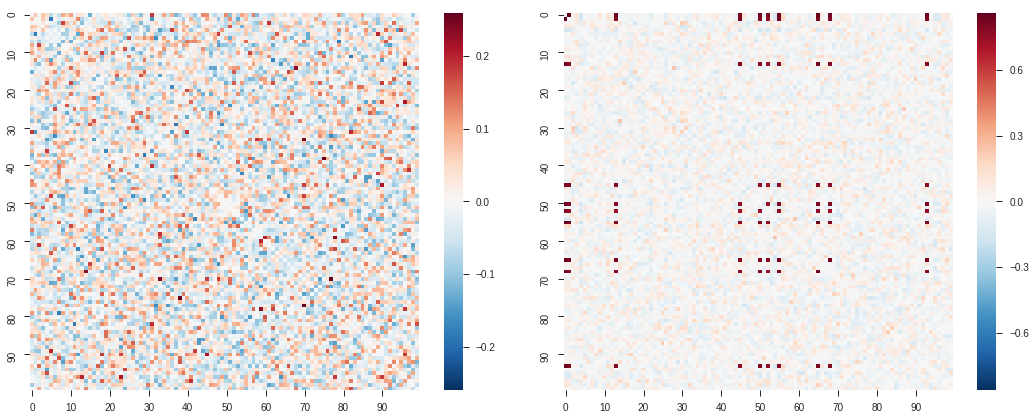

In [9]:
corr_matrix_1 = matstat.corr_matrix(spiketrain_list_1)
corr_matrix_2 = matstat.corr_matrix(spiketrain_list_2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()
matstat.plot_matrix(corr_matrix_1, ax[0], remove_autocorr=True)
matstat.plot_matrix(corr_matrix_2, ax[1], remove_autocorr=True)

#### Eigenvalue distribution


Eigenvalue distribution:
	EW_max = 2.49
	EW_min = 0.14

Redundancy = 0.06 


Eigenvalue distribution:
	EW_max = 8.55
	EW_min = 0.07

Redundancy = 0.10 



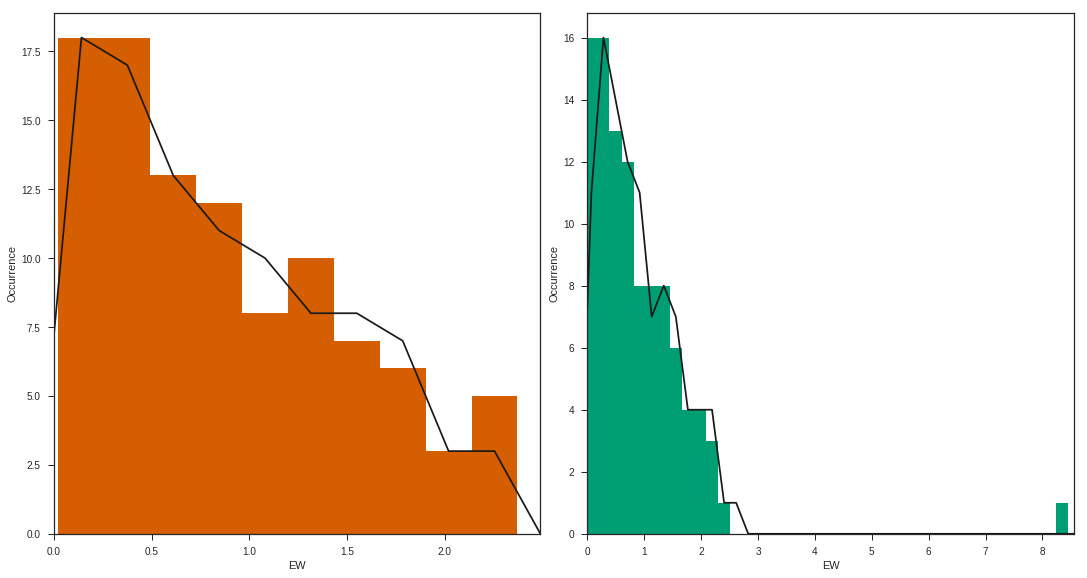

In [10]:
EWs_1, EVs_1 = eigh(corr_matrix_1)
EWs_2, EVs_2 = eigh(corr_matrix_2)

# Generate surrogates as reference
def generate_ref(spiketrain_list):
    surrogate_spiketrain_list = testdata.generate_surrogates(spiketrain_list, 
                                                             dither_spikes, #_train, 
                                                             dither=10*ms) #shift
    surrogate_corr_matrix = matstat.corr_matrix(surrogate_spiketrain_list)
    return eigh(surrogate_corr_matrix)[0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
fig.tight_layout()
__ = matstat.eigenvalue_distribution(EWs_1, ax[0], 
                                     reference_EWs=generate_ref(spiketrain_list_1),
                                     binnum=int(max(EWs_1))*5, color='r')
__ = matstat.redundancy(EWs_1)

__ = matstat.eigenvalue_distribution(EWs_2, ax[1], 
                                     reference_EWs=generate_ref(spiketrain_list_2),
                                     binnum=int(max(EWs_2))*5, color='g')
__ = matstat.redundancy(EWs_2)

#### Eigenvalue spectra


Significance Test:
	Method: SCREE 
	7 of 100 eigenvalues are significant

Princial components:
	0: 2.49
	1: 2.45
	2: 2.37
	3: 2.30
	4: 2.27
	5: 2.18
	6: 2.09


Significance Test:
	Method: SCREE 
	2 of 100 eigenvalues are significant

Princial components:
	0: 8.55
	1: 2.43



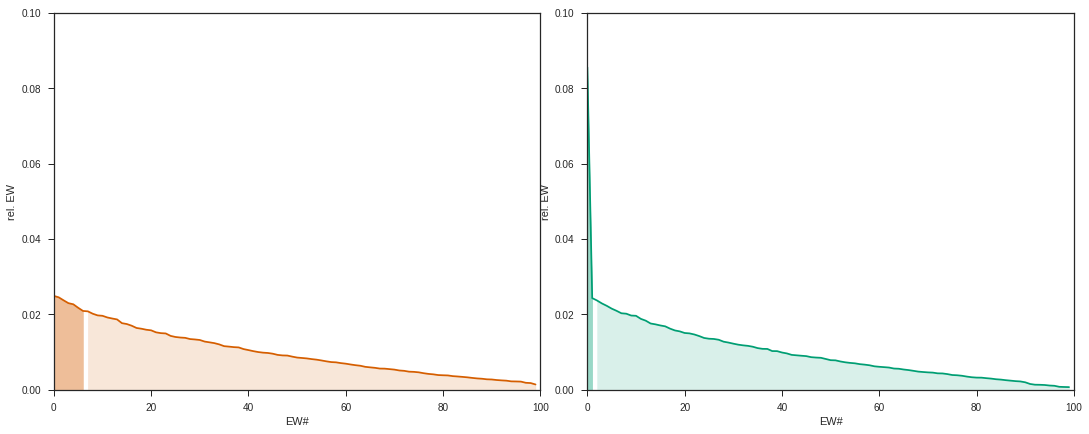

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

pc_nbr_1 = matstat.eigenvalue_spectra(EWs_1, method='SCREE', alpha=.20, ax=ax[0], color='r')
pc_nbr_2 = matstat.eigenvalue_spectra(EWs_2, method='SCREE', ax=ax[1], color='g')

#### Show eigenvectors

In [12]:
if N < 17:
    colormap = [37,37,30,34,32,31,33,36,35] + [47,40,44,42,41,43,46,45]
    matstat.print_eigenvectors(EVs_1, EWs_1, pc_nbr_1, colormap=colormap)
    matstat.print_eigenvectors(EVs_2, EWs_2, pc_nbr_2, colormap=colormap)

#### Angles between eigenspaces

In [13]:
nbr_of_pcs = min(pc_nbr_1, pc_nbr_2)
_ = matstat.EV_angles(EVs_1[:, -nbr_of_pcs:], EVs_2[:, -nbr_of_pcs:])


Angles between the eigenvectors
	68.18°
	54.20°

Angle between eigenspaces
	89.08°


#### Detect Assemblies

In [14]:
print "\033[36mSample 1\033[0m\n"
corr_order_1 = matstat.detect_assemblies(EVs_1, EWs_1, detect_by='eigenvalues', sort=True, jupyter=True)
print "\033[36mSample 2\033[0m\n"
corr_order_2 = matstat.detect_assemblies(EVs_2, EWs_2, detect_by=10, EW_lim=3, sort=True, jupyter=True)

Sample 1

Assembly 1, eigenvalue 2.49, size 3
Neuron ID:	38	35	97		Norm
Portion:	0.23	0.21	0.20		0.37

Assembly 2, eigenvalue 2.45, size 3
Neuron ID:	90	45	80		Norm
Portion:	0.33	0.22	0.20		0.45

Assembly 3, eigenvalue 2.37, size 3
Neuron ID:	31	18	82		Norm
Portion:	0.26	0.25	0.23		0.43

Assembly 4, eigenvalue 2.30, size 3
Neuron ID:	93	66	86		Norm
Portion:	0.26	0.25	0.23		0.43

Assembly 5, eigenvalue 2.27, size 3
Neuron ID:	51	92	21		Norm
Portion:	0.24	0.23	0.23		0.41

Assembly 6, eigenvalue 2.18, size 3
Neuron ID:	89	62	54		Norm
Portion:	0.25	0.24	0.22		0.41

Assembly 7, eigenvalue 2.09, size 3
Neuron ID:	24	78	51		Norm
Portion:	0.30	0.25	0.24		0.46

Assembly 8, eigenvalue 2.08, size 3
Neuron ID:	70	77	96		Norm
Portion:	0.36	0.28	0.26		0.53

Assembly 9, eigenvalue 2.02, size 3
Neuron ID:	48	61	43		Norm
Portion:	0.28	0.25	0.24		0.44

Sample 2

Assembly 1, eigenvalue 8.55, size 10
Neuron ID:	 0	65	55	 1	93	13	68	50	45	52		Norm
Portion:	0.32	0.31	0.31	0.31	0.31	0.31	0.31	0.30	0.30	0.29	

#### Show Assemblies in Correlation Matrix

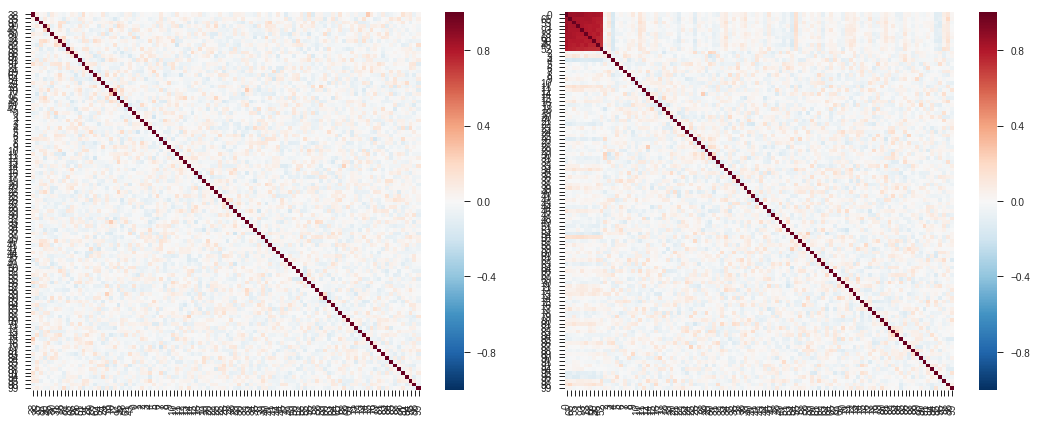

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.tight_layout()

matstat.plot_matrix(corr_matrix_1[corr_order_1, :][:, corr_order_1], ax[0], labels=corr_order_1, remove_autocorr=False)
matstat.plot_matrix(corr_matrix_2[corr_order_2, :][:, corr_order_2], ax[1], labels=corr_order_2, remove_autocorr=False)